In [3]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask_ml.preprocessing import StandardScaler as DaskScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from imblearn.over_sampling import SMOTE

# Função para carregar e pré-processar os dados usando Dask
def process_data(filepath, cols_to_use):
    df = dd.read_csv(filepath, usecols=cols_to_use)
    df = df.drop_duplicates().fillna(df.mean())
    scaler = DaskScaler()
    df = scaler.fit_transform(df)
    return df

# Função para adicionar rótulos
def add_labels(df, label):
    df['label'] = label
    return df

# Função para processar arquivos em uma pasta
def process_files_in_folder(folder_path, cols_to_use, label):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    dfs = []
    for file in files:
        df = process_data(file, cols_to_use)
        df = add_labels(df, label)
        dfs.append(df)
    if dfs:
        combined_df = dd.concat(dfs, axis=0)
        print(f"Processado {len(dfs)} arquivos para a pasta {label} com {combined_df.shape[0].compute()} linhas.")
        return combined_df
    else:
        print(f"Nenhum arquivo CSV encontrado em {folder_path}.")
        return None

# Função para processar todas as pastas
def process_all_folders(base_path, subfolders):
    folder_dfs = []
    for subfolder in subfolders:
        folder_path = os.path.join(base_path, subfolder)
        if os.path.exists(folder_path):
            df = process_files_in_folder(folder_path, ['v:X0014A', 'v:X0014B', 'v:X0014C', 'v:X0013A', 'v:X0013B', 'v:X0013C',
                                                        'c:X0013A:BUS8A', 'c:X0013B:BUS8B', 'c:X0013C:BUS8C',
                                                        'c:BUS9A:X0014A', 'c:BUS9B:X0014B', 'c:BUS9C:X0014C'], subfolder)
            if df is not None:
                folder_dfs.append(df)
            else:
                print(f"Nenhuma DataFrame criado para a pasta {subfolder}.")
        else:
            print(f"Pasta {folder_path} não encontrada.")
    if folder_dfs:
        final_df = dd.concat(folder_dfs, axis=0)
        return final_df
    else:
        print("Nenhum DataFrame foi criado a partir das pastas. Verifique os caminhos e dados.")
        return dd.from_pandas(pd.DataFrame(), npartitions=1)

base_path = 'D:/base'  
subfolders = ['AB', 'ABC', 'ABG', 'AC', 'ACG', 'AG', 'BG', 'BCG', 'BC', 'CG']

with ProgressBar():
    final_df = process_all_folders(base_path, subfolders).compute()

if 'label' in final_df.columns:
    X = final_df.drop('label', axis=1)
    y = final_df['label']
else:
    raise Exception("A coluna 'label' não foi encontrada no DataFrame. Verifique o pré-processamento dos dados.")


# Função para balancear as classes
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = balance_classes(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nModelo: Random Forest")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {fscore}")


[########################################] | 100% Completed | 103.17 ms
[########################################] | 100% Completed | 102.63 ms
[########################################] | 100% Completed | 102.84 ms
[########################################] | 100% Completed | 103.64 ms
[########################################] | 100% Completed | 103.39 ms
[########################################] | 100% Completed | 103.87 ms
[########################################] | 100% Completed | 103.21 ms
[########################################] | 100% Completed | 103.05 ms
[########################################] | 100% Completed | 103.54 ms
[########################################] | 100% Completed | 103.24 ms
[########################################] | 100% Completed | 103.10 ms
[########################################] | 100% Completed | 104.69 ms
[########################################] | 100% Completed | 102.65 ms
[########################################] | 100% Completed | 10

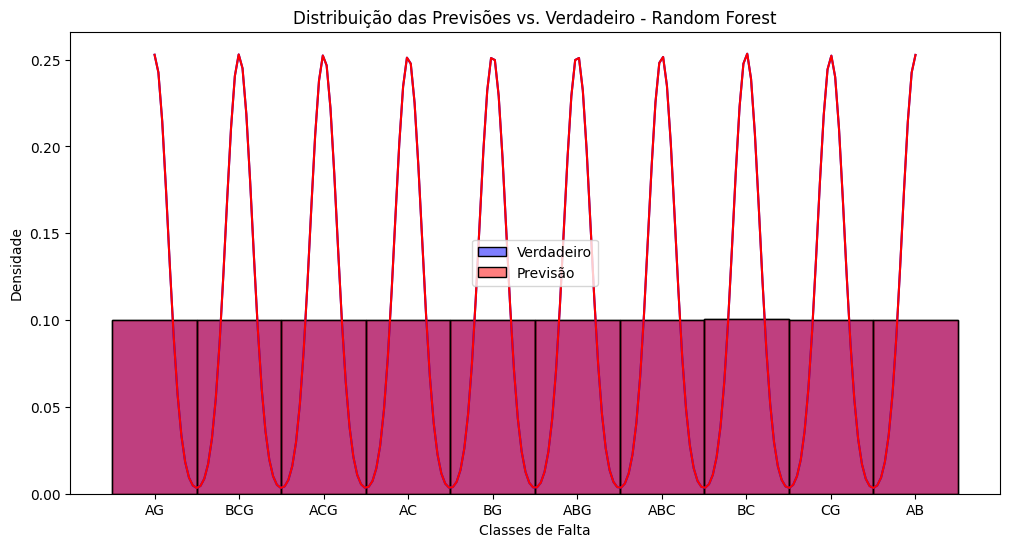

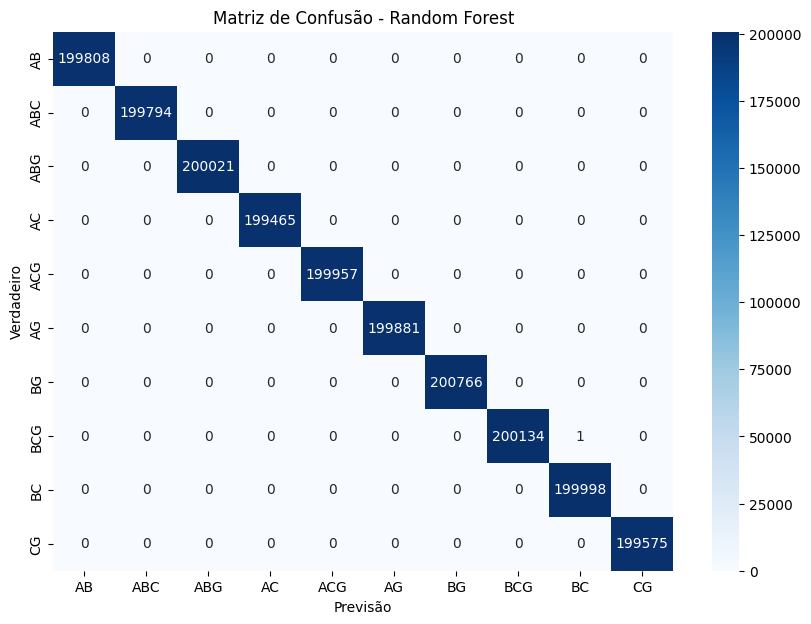

In [4]:
def plot_predictions_vs_true(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    sns.histplot(y_test, color='blue', label='Verdadeiro', kde=True, stat="density", bins=30)
    sns.histplot(y_pred, color='red', label='Previsão', kde=True, stat="density", bins=30)
    plt.title('Distribuição das Previsões vs. Verdadeiro - Random Forest')
    plt.xlabel('Classes de Falta')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão - Random Forest')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.show()
# Plotando os histogramas de previsão vs verdadeiro
plot_predictions_vs_true(y_test, y_pred)

# Plotando a matriz de confusão
# Obtendo os rótulos únicos para passar para a função de plotagem da matriz de confusão
labels = y.unique().compute() if isinstance(y, dd.Series) else y.unique()
plot_confusion_matrix(conf_matrix, labels=labels)
